# Book Recommendation Engine using KNN

Éste proyecto es un challenge de FreeCodeCamp para modelos de Machine Leargnin de clustering. <br> [Link del challenge.](https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/book-recommendation-engine-using-knn)

## Importamos librerías y datos

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-12-13 18:32:32--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.2’

book-crossings.zip. 100%[===================>]  24.88M   102MB/s    in 0.2s    

2023-12-13 18:32:32 (102 MB/s) - ‘book-crossings.zip.2’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

## Analizamos df_books

In [ ]:
books_clean = df_books.copy()

In [ ]:
books_clean.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
books_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271378 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB


Encontramos un registro con su autor con valor Nulo, sin embargo, el nombre del autor no es relevante para el objetivo de este proyecto.

Revisamos si hay duplicados

In [ ]:
books_clean.duplicated().sum()

0

Verificamos si hay ISBNs duplicados (el ISBN es único para cada libro)

In [ ]:
books_clean['isbn'].duplicated().sum()

0

Verificamos si hay valores de ISBNs en blanco (el método value_counts nos muestra al final de la jerarquía si existen)

In [ ]:
books_clean['isbn'].value_counts()

0195153448    1
0785339876    1
077108482X    1
0207124310    1
0439172543    1
             ..
2877306127    1
0679869832    1
1584850884    1
2743603518    1
0767409752    1
Name: isbn, Length: 271379, dtype: int64

Verificamos si no hay blancos en el título de los libros

In [ ]:
books_clean['title'].value_counts()

Selected Poems                                                                                                                    27
Little Women                                                                                                                      24
Wuthering Heights                                                                                                                 21
The Secret Garden                                                                                                                 20
Dracula                                                                                                                           20
                                                                                                                                  ..
Cinderella'S Secret Agent (A Year Of Loving Dangerously) (Silhouette Intimate Moments, No 1076)                                    1
Diamond In The Rough (Temptation , No 688)                           

Conclusión: En éste análisis de datos inicial del dataframe de libros nos enfocamos en las columnas que nos dan información (ISBN y TITLE). No encontramos nulos ni blancos.

## Analizamos df_rating

In [ ]:
ratings_clean = df_ratings.copy()

In [ ]:
ratings_clean.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
ratings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


No se encuetran valores nulos ⬆

In [ ]:
ratings_clean.duplicated().sum()

0

In [ ]:
ratings_clean.duplicated(['user', 'isbn']).sum()

0

No se encuetran duplicados ⬆

In [ ]:
ratings_clean['isbn'].value_counts()

0971880107     2502
0316666343     1295
0385504209      883
0060928336      732
0312195516      723
               ... 
1568656386        1
1568656408        1
1569551553        1
1570081808        1
05162443314       1
Name: isbn, Length: 340556, dtype: int64

No se encuentran valores ISBNs en blanco ⬆

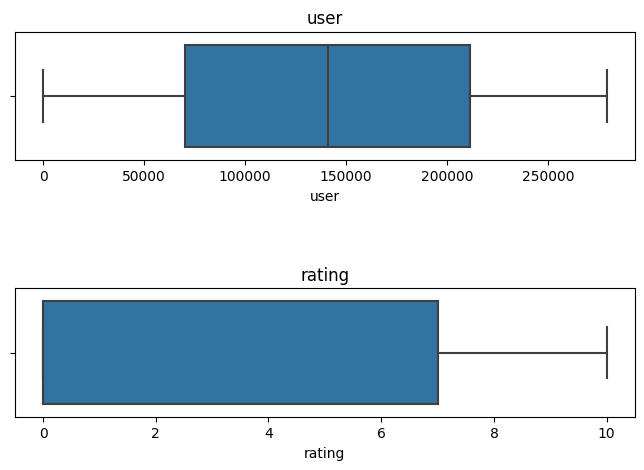

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,5))
fig.subplots_adjust(hspace=1)

for index, column in enumerate(['user', 'rating']):
  seaborn.boxplot(x=column, data=ratings_clean, ax=ax[index])
  ax[index].set_title(column)

No observamos valores de usuarios anómalos (negativos) ni tampoco valores anómalos en rating (negativos ni mayores a 10) ⬆

In [ ]:
print(f'Books clean rows: {books_clean.shape[0]} \nRatings clean rows: {ratings_clean.shape[0]}')

Books clean rows: 271379 
Ratings clean rows: 1149780


## Limpiamos los datasets y nos quedamos con la información más significativa

### Eliminamos los libros que tengan menos de 100 calificaciones

In [ ]:
books_ratings = books_clean.merge(ratings_clean, on='isbn')
books_ratings.head()

,isbn,title,author,user,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,8,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,11400,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,41385,0.0


Verificamos si como resultado del merge hubieron efectos no deseados

In [ ]:
books_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031175 entries, 0 to 1031174
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   isbn    1031175 non-null  object 
 1   title   1031175 non-null  object 
 2   author  1031174 non-null  object 
 3   user    1031175 non-null  int32  
 4   rating  1031175 non-null  float32
dtypes: float32(1), int32(1), object(3)
memory usage: 39.3+ MB


In [ ]:
books_ratings.duplicated(['isbn', 'title', 'author', 'user', 'rating']).sum()

0

In [ ]:
books_ratings.isnull().sum()

isbn      0
title     0
author    1
user      0
rating    0
dtype: int64

In [ ]:
books_ratings.head()

,isbn,title,author,user,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,8,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,11400,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,41385,0.0


Agrupamos los libros por ISBN y después contamos por cada ISBN cuántas veces fueron clasificados.

In [ ]:
books_ratings_isbn = books_ratings.groupby(by='isbn').aggregate({'rating': 'count'})
books_ratings_isbn.rename(columns={'rating': 'rating_count'}, inplace=True)
books_ratings_isbn

,rating_count
isbn,
0000913154,1
0001010565,2
0001046438,1
0001046713,1
000104687X,1
...,...
B000234N76,1
B000234NC6,1
B00029DGGO,1


Nos quedamos con los ISBNs que tienen 100 o más clasificaciones

In [ ]:
criteria = books_ratings_isbn['rating_count'] >= 100
isbns_more_than_100_ratings = books_ratings_isbn[criteria].index
isbns_more_than_100_ratings

Index(['002542730X', '0060008032', '0060096195', '006016848X', '0060173289',
       '0060175400', '006019491X', '0060199652', '0060391626', '0060392452',
       ...
       '1558744630', '1558745157', '1559029838', '1573225517', '1573225789',
       '1573227331', '1573229326', '1573229571', '1592400876', '1878424319'],
      dtype='object', name='isbn', length=727)

Filtramos los libros y obtenemos todos aquellos libros que tienen 100 o más clasificaciones y el resultado lo almacenamos en el dataframe final_book

In [ ]:
criteria = books_clean['isbn'].isin(isbns_more_than_100_ratings)
final_books = books_clean[criteria]
final_books

,isbn,title,author
18,0440234743,The Testament,John Grisham
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison
26,0971880107,Wild Animus,Rich Shapero
27,0345402871,Airframe,Michael Crichton
28,0345417623,Timeline,MICHAEL CRICHTON
...,...,...,...
28072,0425178765,Easy Prey,John Sandford
29215,0449223604,M Is for Malice,Sue Grafton
30535,0345444884,The Talisman,STEPHEN KING
30775,0060008032,Angels,Marian Keyes


In [ ]:
print(f'books_clean rows: {books_clean.shape[0]} \nfinal_books rows: {final_books.shape[0]}')

books_clean rows: 271379 
final_books rows: 727


Conclusion: de los 271379 ISBNs sólo 727 tienen 100 o más calificaciones

### Eliminamos los usuarios que hayan hecho menos de 200 calificaciones

In [ ]:
ratings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


Hacemos una agrupación por usuario y efectuamos el total de calificaciones que realizó cada usuario

In [ ]:
users_ratings_count = ratings_clean.groupby(by='user').aggregate({'rating': 'count'}).rename(columns={'rating': 'rating_count'})
users_ratings_count

,rating_count
user,
2,1
7,1
8,18
9,3
10,2
...,...
278846,2
278849,4
278851,23


Filtramos y nos quedamos con todos aquellos usuarios que han calificado 200 o más veces

In [ ]:
condition = users_ratings_count['rating_count'] >= 200
users_more_than_200_ratings = users_ratings_count[condition].index
users_more_than_200_ratings

Int64Index([   254,   2276,   2766,   2977,   3363,   3757,   4017,   4385,
              6242,   6251,
            ...
            274004, 274061, 274301, 274308, 274808, 275970, 277427, 277478,
            277639, 278418],
           dtype='int64', name='user', length=905)

Filtramos aquellos usuarios

In [ ]:
final_ratings = ratings_clean[ratings_clean['user'].isin(users_more_than_200_ratings)]
final_ratings

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


Verificamos en el nuevo dataframe si obtuvimos el resultado esperado

In [ ]:
final_ratings.groupby(by='user').aggregate({'rating': 'count'}).rename(columns={'rating': 'rating_count'}).sort_values('rating_count', ascending=True)

,rating_count
user,
26883,200
99955,200
252827,200
36554,200
83671,200
...,...
35859,5850
98391,5891
153662,6109


In [ ]:
print(f'ratings_clean rows: {ratings_clean.shape[0]} \nfinal_ratings rows: {final_ratings.shape[0]}')

ratings_clean rows: 1149780 
final_ratings rows: 527556


Sólo cerca del 50% de todos los usuarios han calificado libros 200 o más veces

Reiniciamos índices luego de la limpieza

In [ ]:
final_ratings = final_ratings.reset_index(drop=True)

In [ ]:
final_books = final_books.reset_index(drop=True)

## Implementamos nuestro modelo de Machine Learning

### Preparamos los datos

In [ ]:
final_data = final_books.merge(final_ratings, on='isbn')
final_data

,isbn,title,author,user,rating
0,0440234743,The Testament,John Grisham,277478,0.0
1,0440234743,The Testament,John Grisham,2977,0.0
2,0440234743,The Testament,John Grisham,3363,0.0
3,0440234743,The Testament,John Grisham,7346,9.0
4,0440234743,The Testament,John Grisham,9856,0.0
...,...,...,...,...,...
49512,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,236283,0.0
49513,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,251613,0.0
49514,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,252071,0.0
49515,0515135739,Eleventh Hour: An FBI Thriller (FBI Thriller (...,Catherine Coulter,256407,0.0


In [ ]:
final_data.duplicated().sum()

0

In [ ]:
final_data.duplicated(['isbn', 'user']).sum()

0

In [ ]:
books_pivot = final_data.pivot_table(index='title', columns='user', values='rating')
books_pivot

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
books_pivot.fillna(0, inplace=True)

In [ ]:
books_pivot

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Instanciamos y entrenamos nuestro modelo

In [ ]:
books_sparse = csr_matrix(books_pivot)

In [ ]:
knn = NearestNeighbors(metric='cosine')
knn.fit(books_sparse)

NearestNeighbors(metric='cosine')

## Creamos la función de recomendación

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book_name):
  book_id = numpy.where(books_pivot.index == book_name)[0][0]
  distance, suggestion = knn.kneighbors(books_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=6)
  books = books_pivot.index[suggestion[0]]
  distances = distance[0]
  recomended_books = []
  others = []
  for index, book in enumerate(books):
    if book == book_name:
      recomended_books.append(book)
    else:
      others.append([book, distances[index].round(2)])
  others.reverse()
  recomended_books.append(others)
  return recomended_books

In [ ]:
get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [["I'll Be Seeing You", 0.8],
  ['The Weight of Water', 0.77],
  ['The Surgeon', 0.77],
  ['I Know This Much Is True', 0.77],
  ['The Lovely Bones: A Novel', 0.72]]]

## Testeamos nuestro modelo

La función de testeo ya viene con el proyecto del challenge.<br> Verificamos si nuestro modelo cumple con el nivel de precisión requerido y si el resultado de nuestra función es el esperado.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8], ['The Weight of Water', 0.77], ['The Surgeon', 0.77], ['I Know This Much Is True', 0.77], ['The Lovely Bones: A Novel', 0.72]]]
You passed the challenge! 🎉🎉🎉🎉🎉
